# Energy Forecast with PJM Hourly Energy Consumption data

#### About dataset:

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

<center><img src="https://i.postimg.cc/dQm3zGyF/download.png" width="800"/></center>


Ideas of what you could do with this dataset:

Split the last year into a test set- can you build a model to predict energy consumption?

Find trends in energy consumption around hours of the day, holidays, or long term trends?

Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.


## Imports

In [115]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

# # This relates to plotting datetime values with matplotlib:
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

## Load the dataset:

**We locate the file with all the data for all the different regions:**

In [93]:
df = pd.read_csv('data/pjm_hourly_est.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AEP       121273 non-null  float64
 1   COMED     66497 non-null   float64
 2   DAYTON    121275 non-null  float64
 3   DEOK      57739 non-null   float64
 4   DOM       116189 non-null  float64
 5   DUQ       119068 non-null  float64
 6   EKPC      45334 non-null   float64
 7   FE        62874 non-null   float64
 8   NI        58450 non-null   float64
 9   PJME      145366 non-null  float64
 10  PJMW      143206 non-null  float64
 11  PJM_Load  32896 non-null   float64
dtypes: float64(12)
memory usage: 17.7 MB


**Let us plot the data in each column to get an idea of their timeframes:**

Text(0, 0.5, 'hourly consumption [MW]')

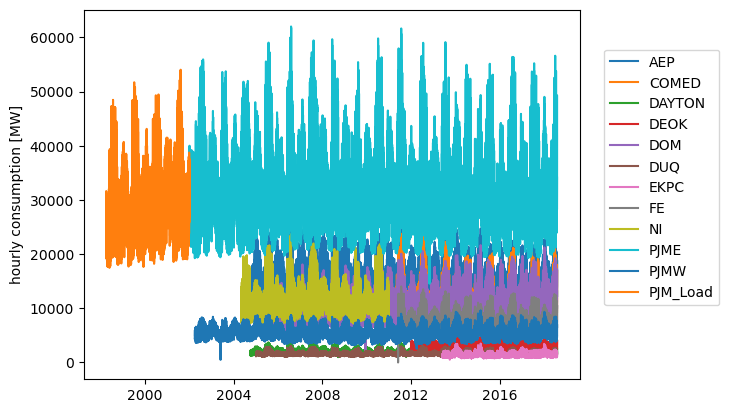

In [94]:
for col in df.columns:

    plt.plot(df[col], label=col)

plt.legend(loc=(1.05, 0.2))
plt.ylabel('hourly consumption [MW]')

**From now on we choose to work with the PJME data.**

In [95]:
df = pd.read_csv('data/PJME_hourly.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


**Let us zoom in and plot one year to see some seasonal trends:**

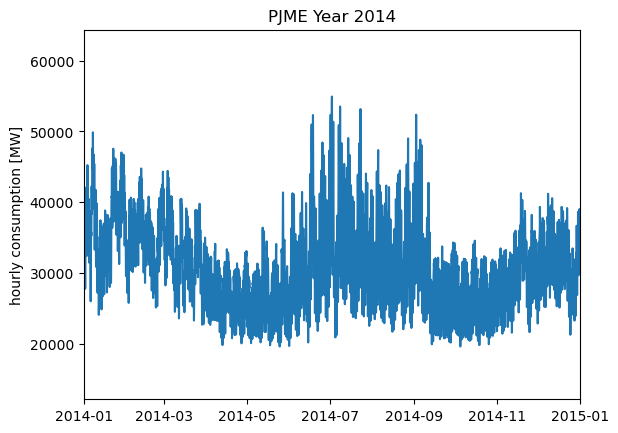

In [96]:
plt.plot(df['PJME_MW'])
plt.xlim(pd.Timestamp('2014-01'), pd.Timestamp('2015-01'))
plt.title('PJME Year 2014')
plt.ylabel('hourly consumption [MW]')
plt.show()

## Prepare the data

**We will divide the data into train/test sets and normalize the training values so that they fall between -1 and 1 (to improve training). Then we will train the model, and predict into a period that matches the test set. Finally, we'll forecast into an unknown future.**

### Create the train / validation split

**We choose the test size to be 90 days, and the training set to be 3 years**

In [111]:
y = df['PJME_MW'].values.astype(float)

# Define a test size
test_size = 24 * 90

# Define a training size
train_size = 24 * 365 * 3

# Create train and test sets
train_set = y[-train_size:-test_size]
test_set = y[-test_size:]

In [112]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

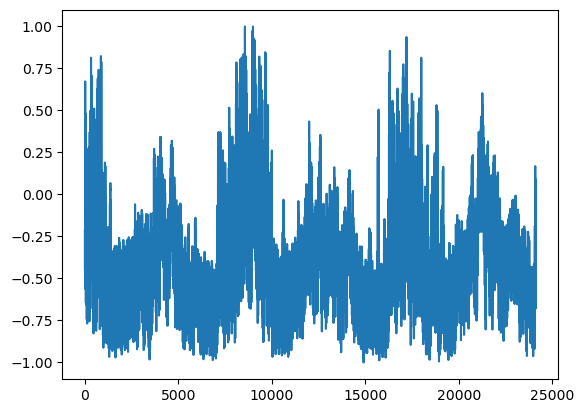

In [113]:
plt.plot(train_norm)

## Prepare data for LSTM

**We create our list of (seq, label) tuples from the training set**

**We choose the window to be a week (168 h), in order to capture seasonalities but not make it too large.**

In [120]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 168

# Define function to create (seq, label) tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

23952

In [121]:
# Display the first (seq, label) tuple in the train data
train_data[0]

(tensor([-0.2119, -0.3216, -0.3988, -0.4493, -0.4562, -0.3934, -0.2950, -0.1814,
         -0.0476,  0.0991,  0.2476,  0.3703,  0.4705,  0.5501,  0.6040,  0.6434,
          0.6733,  0.6642,  0.5809,  0.4525,  0.3601,  0.2501,  0.0443, -0.1612,
         -0.3301, -0.4442, -0.5183, -0.5628, -0.5623, -0.4984, -0.3989, -0.2917,
         -0.1807, -0.0591,  0.0674,  0.1786,  0.2710,  0.3442,  0.4024,  0.4474,
          0.4817,  0.4796,  0.4057,  0.2882,  0.2156,  0.1163, -0.0719, -0.2702,
         -0.4239, -0.5326, -0.6012, -0.6450, -0.6422, -0.5786, -0.4868, -0.3679,
         -0.2675, -0.1748, -0.0784,  0.0051,  0.0768,  0.1442,  0.1934,  0.2226,
          0.2206,  0.1943,  0.1167,  0.0528,  0.0498, -0.0266, -0.1762, -0.3300,
         -0.4683, -0.5628, -0.6242, -0.6560, -0.6514, -0.5844, -0.4935, -0.3805,
         -0.2790, -0.1883, -0.0997, -0.0336,  0.0169,  0.0724,  0.1230,  0.1610,
          0.1845,  0.1750,  0.1105,  0.0162, -0.0273, -0.0931, -0.2342, -0.3880,
         -0.5233, -0.6183, -